# OpenAI API 使用

## Token 是什么

Token 是 OpenAI 模型理解和处理文本的方式。它们将文本分解为更小的部分，以便模型能够更好地理解文本之间的关系。Token 和单词不是一一对应的，比如，一个单词可以被分解为多个 Token，而一个 Token 也可以由多个单词组成。

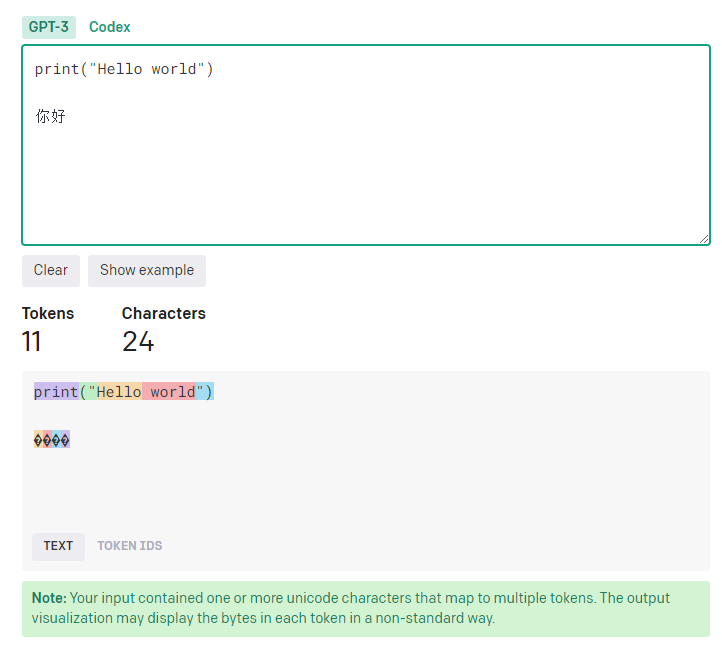

https://platform.openai.com/tokenizer

In [ ]:
!pip install tiktoken

In [ ]:
import tiktoken

OpenAI 不同的模型使用的 Token 编码方式是不同的。

| Encoding name           | OpenAI models                                       |
|-|-|
| `cl100k_base`           | `gpt-4`, `gpt-3.5-turbo`, `text-embedding-ada-002`  |
| `p50k_base`             | Codex models, `text-davinci-002`, `text-davinci-003`|
| `r50k_base` (or `gpt2`) | GPT-3 models like `davinci`  |

In [ ]:
encoding = tiktoken.get_encoding("p50k_base")
# or
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
# encoding = tiktoken.encoding_for_model("text-davinci-003")


用 `encode` 方法将文本转换为 Token。

In [ ]:
hello_token = encoding.encode("你好")
hello_token

In [ ]:
print(encoding.decode(hello_token))
# 解码单个 token
print([encoding.decode([token]) for token in hello_token])


In [ ]:
tokens = [encoding.decode_single_token_bytes(token) for token in hello_token]
print(tokens)


In [ ]:
(tokens[0] + tokens[1]).decode("utf-8")



## 模型种类

OpenAI 模型从功能上可以分为三大类：补全（completion）、对话（chat）、嵌入（embeddings）

### 补全

补全模型可以根据输入的文本，补全剩余的文本。

### 对话

对话模型是专门为对话场景设计的模型。对话模型可以根据上文，生成下文。对话模型的输入是一个对话历史，输出是下一句话。

### 嵌入（Embedding）

嵌入模型可以将文本转换为向量。这类模型可以用于文本分类、聚类、搜索等任务。

## API 参数

https://platform.openai.com/docs/api-reference

- `model` 指定使用的模型。
- `prompt` 是输入给模型的文本。
- `temperature` 控制了生成文本的随机程度，值越大，生成的文本越随机，值越小，生成的文本越稳定。这个值的范围在 0.0 到 2.0 之间。
- `top_p` 与 `temperature` 类似，也是控制生成文本的随机程度。但这个参数简单的说是控制候选词的范围，值越大，候选词的范围越大，值越小，候选词的范围越小。这个值的范围在 0.0 到 1.0 之间。通常来说，这两个参数只需要设置一个就可以了。
- `max_tokens` 是模型生成的文本的最大长度。
- `stop` 是生成文本的停止条件，当生成的文本中包含这个字符串时，生成过程就会停止,最终生成的文本中将不包含这个字符串。这个参数可以是一个 string，也可以是一个长度至多为 4 的 string 列表。
- `presence_penalty` 控制生成文本的多样性。他会惩罚那些在生成文本中已经出现过的 token，以减小未来生成这些 token 的概率。这个值的范围在 -2.0 到 2.0 之间。如果设为负值，那么惩罚就会变为奖励，这样就会增加生成这些 token 的概率。
- `frequency_penalty` 与 `presence_penalty` 类似，也是控制生成文本的多样性。但不同的是，`presence_penalty` 是一次性惩罚，而 `frequency_penalty` 累计惩罚。如果一个词在生成文本中出现了多次，那么这个词在未来生成的概率就会越来越小。这个值的范围同样在 -2.0 到 2.0 之间。

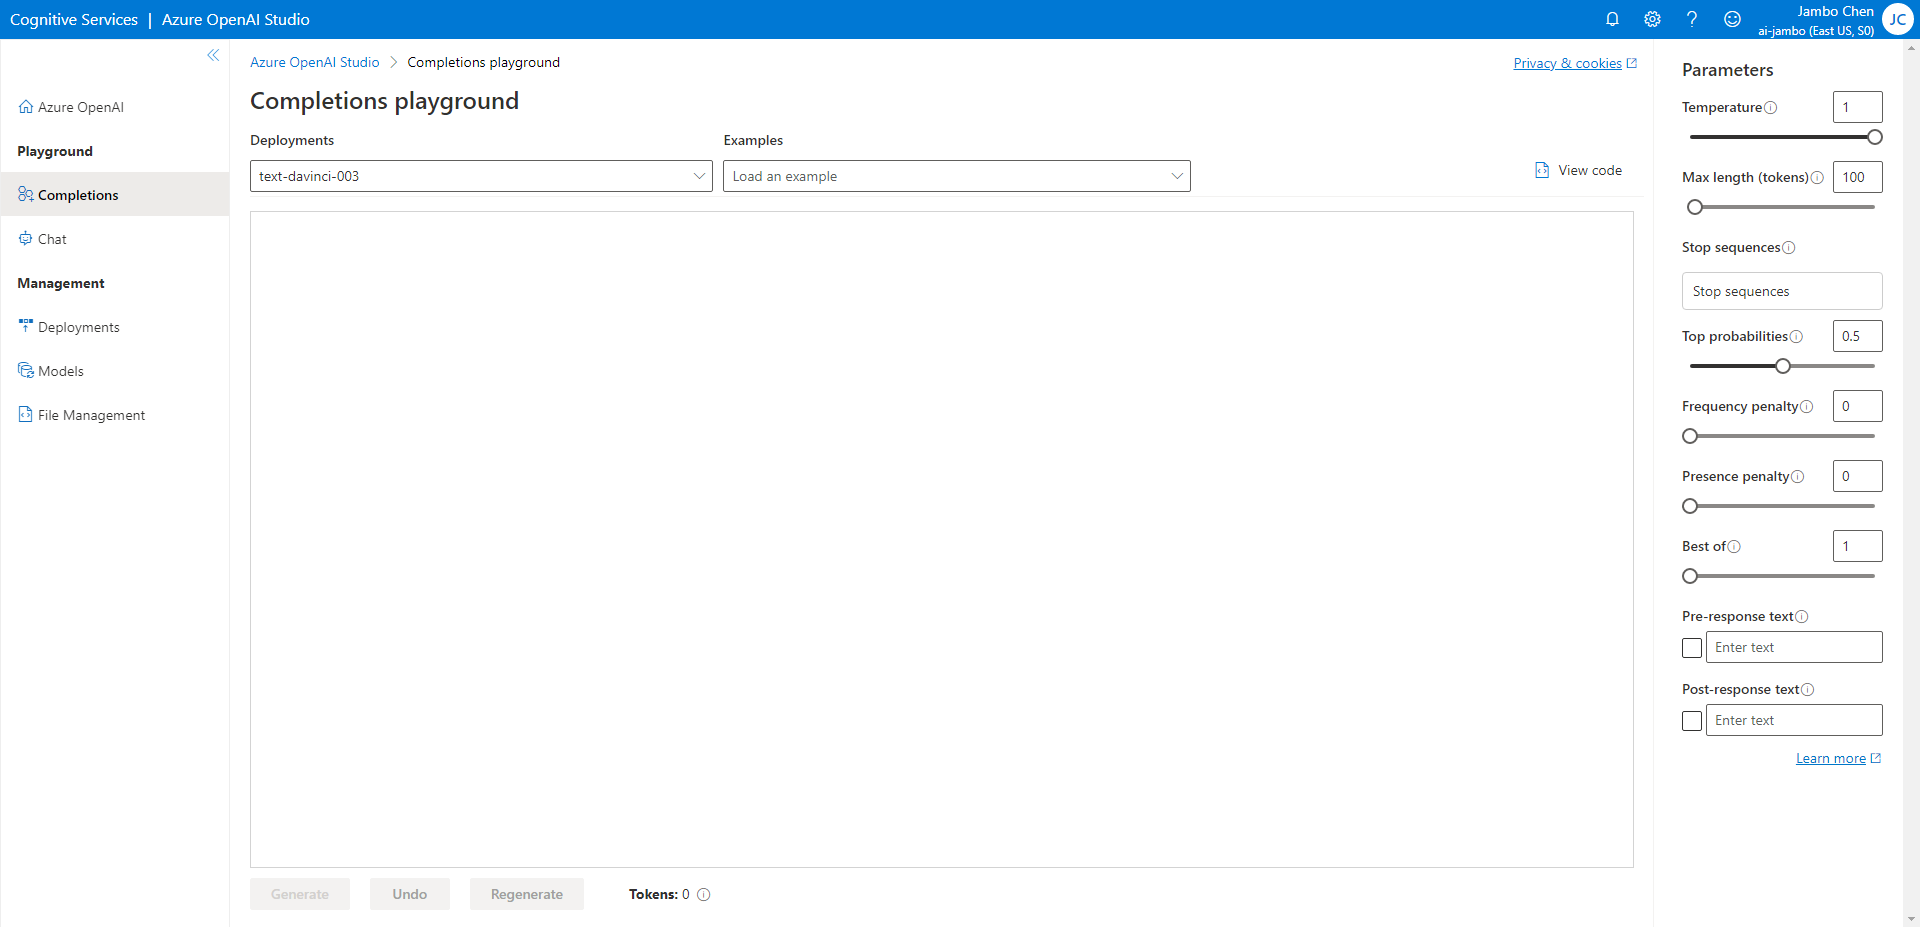

## 调用 API

Python：https://github.com/openai/openai-python

```bash
pip install openai
```

In [ ]:
!pip install openai

In [ ]:
import openai
import json

with open("../config.json") as f:
    config = json.load(f)

# 设置 API
openai.api_key = config["api_key"]
openai.api_base = config["api_base"]
openai.api_type = "azure"
openai.api_version = "2023-03-15-preview"  # this may change in the future
model = "gpt-35-turbo"  # Model deployment name


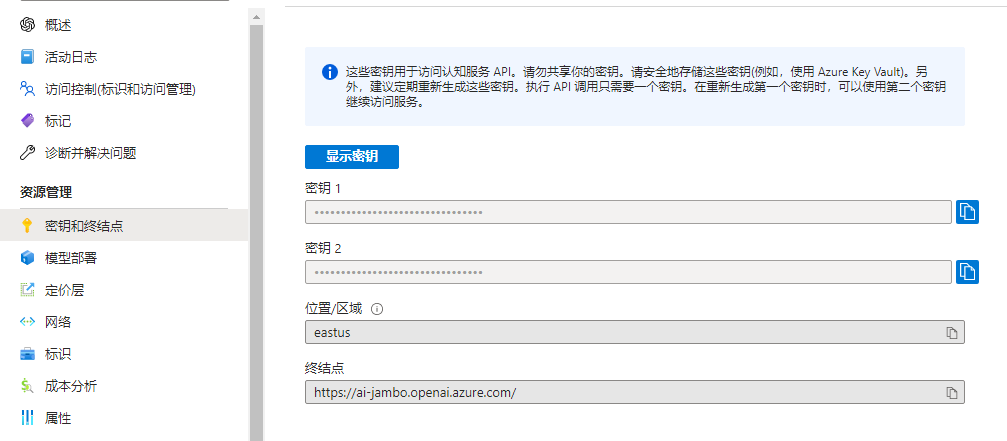

### openai.Completion()

In [ ]:
prompt = "1, 2, 3, 4, "
response = openai.Completion.create(
    engine=model, prompt=prompt, max_tokens=50, temperature=0.0
)
print(response)

`finish_reason`：停止原因，可以是 `length` / `stop`。
`usage`：Token 的使用情况
- `completion_tokens`：生成了多少个 Token
- `prompt_tokens`：输入了多少个 Token
- `total_tokens`：总共使用了多少个 Token

添加 `stop` 参数，可以防止生成的文本过长，也可以避免生成不必要的内容。

In [ ]:
prompt = "1, 2, 3, 4, "
response = openai.Completion.create(
    engine=model, prompt=prompt, temperature=0, stop=["11"]
)
print(response["choices"][0])

### openai.ChatCompletion()

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Does Azure OpenAI support customer managed keys?"},
    {
        "role": "assistant",
        "content": "Yes, customer managed keys are supported by Azure OpenAI.",
    },
    {"role": "user", "content": "Do other Azure Cognitive Services support this too?"},
]

response = openai.ChatCompletion.create(
    engine=model, messages=messages, temperature=0.8
)
response


`role` 表示说话的角色，可以是 `system`/`user`/`assistant`。

In [ ]:
conversation = [{"role": "system", "content": "You are a helpful assistant."}]
# [{"role": "system", "content": "You are a helpful assistant."}]

while user_input := input():
    conversation.append({"role": "user", "content": user_input})
    print("Thinking...")
    response = openai.ChatCompletion.create(
        engine=model,
        messages=conversation,
    )

    conversation.append(
        {"role": "assistant", "content": response.choices[0].message.content}
    )
    print("\n" + response.choices[0].message.content + "\n")
print(conversation)

### 流式生成

In [ ]:
response = openai.ChatCompletion.create(
    engine=model,
    messages=[
        {"role": "user", "content": "用 Python 写一个汉内塔"},
    ],
    temperature=0.5,
    stream=True,
)
next(response)
# for chunk in response:
#     print(chunk.choices[0].delta.get("content", ""), end="")

while delta := next(response).choices[0].delta:
    print(delta["content"], end="")


In [ ]:
response = openai.ChatCompletion.create(
    engine=model,
    messages=[
        {"role": "user", "content": "Count to 10. E.g. 1, 2, 3, 4, ..."},
    ],
    temperature=0,
    stream=True,
)
print(next(response))
for chunk in response:
    print(chunk.choices)


### 异步调用

异步可以让我们等待结果的同时，继续执行其他的代码，这样就不会阻塞程序的执行了。

In [ ]:
import random
import time


def wait_for_response(n: int):
    t = random.randint(1, 2)
    time.sleep(t)
    print(f"{n}: {t} seconds")


def main():
    for i in range(5):
        wait_for_response(i)


start = time.time()
main()
print(f"Total time: {time.time() - start}")


In [ ]:
import random
import asyncio

async def wait_for_response(n:int):
    t = random.randint(1, 2)
    await asyncio.sleep(t)
    print(f"{n}: {t} seconds")
    
async def main():
    await asyncio.gather(*[wait_for_response(i) for i in range(5)])

start = time.time() 
await main()
print(f"Total time: {time.time() - start}")

In [ ]:
async def async_completion():
    response = await openai.ChatCompletion.acreate(
        engine=model,
        messages=[
            {"role": "user", "content": "Count to 10. E.g. 1, 2, 3, 4, ..."},
        ],
        temperature=0,
    )
    return response.choices[0].message


print(await async_completion())


手动传入 aiohttp.ClientSession 对象

In [ ]:
from aiohttp import ClientSession
import asyncio

openai.aiosession.set(ClientSession())
res = await asyncio.gather(*[async_completion() for _ in range(10)])
await openai.aiosession.get().close()
res


参考资料：
- OpenAI API Reference: https://platform.openai.com/docs/api-reference
- openai/openai-cookbook: https://github.com/openai/openai-cookbook
- 